In [2]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import datetime

def categorize(x):
    if x <= 30: return 0
    elif x <= 50: return 1
    else: return 2

def preprocess_3h(df):

    x = df.copy()

    x['category'] = x['Kp*10'].apply(categorize)

    x['dttm'] = x.apply(
        lambda y: datetime.datetime(
            int(y.year), int(y.month), 
            int(y.day), int(y['hour from']), 0), axis=1)
    
    x_3h = x.sort_values(by='dttm').iloc[:: 3]
    return x_3h

ROOT_PATH = '/content/drive/MyDrive/kp_data'

import os
import glob

files = glob.glob(os.path.join(ROOT_PATH, '*'))

files = dict(map(lambda x: (x.split('/')[-1], x), files))

df = pd.read_csv(
    files['All_browse_data_без_погружения_19971021_20211231_с_пропусками.csv'], 
    encoding='cp1251', na_values='N').pipe(preprocess_3h)
print(df.shape)
df.head()

(70776, 65)


,year,month,day,hour from,hour to,doySin,hourSin,doyCos,hourCos,Dst,...,lg(E>2 MeV),E>2 MeV G16,lg(E>2 MeV) G16,CH_rca (193),CH_rca (211),SW_spd_frcst (193),SW_spd_frcst (211),Unnamed: 62,category,dttm
0,1997,10,21,0,1,-0.505271,0.991445,-0.862961,-0.130526,-14,...,0.715307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 00:00:00
3,1997,10,21,3,4,-0.507126,0.608761,-0.861872,-0.793353,-13,...,0.318573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 03:00:00
6,1997,10,21,6,7,-0.508980,-0.130526,-0.860779,-0.991445,-15,...,0.070838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 06:00:00
9,1997,10,21,9,10,-0.510831,-0.793353,-0.859681,-0.608761,-13,...,0.501584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 09:00:00
12,1997,10,21,12,13,-0.512679,-0.991445,-0.858580,0.130526,-10,...,1.011042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1997-10-21 12:00:00


In [3]:
df.columns

Index(['year', 'month', 'day', 'hour from', 'hour to', 'doySin', 'hourSin',
       'doyCos', 'hourCos', 'Dst', 'Lg_Dst', 'Kp*10', 'KpH', 'AE', 'lg(AE)',
       'ULFgr', 'lg(ULFgr)', 'ULFgeo', 'lg(ULFgeo)', 'ULFimf', 'lg(ULFimf)',
       'ULFden', 'lg(ULFden)', 'B_rtn_r', 'B_rtn_t', 'B_rtn_n', 'B_x',
       'B_gse_y', 'B_gse_z', 'B_gsm_y', 'B_gsm_z', 'B_magn', 'SW_spd',
       'SW_spd_Clip290', 'H_den_SWP', 'lg(H_den_SWP)', 'He_ratio_SWP',
       'lg(He_ratio)', 'Trr_SWP', 'lg(Trr)', ' p=n*v*v/2', 'lg(p)', 'Bs',
       'vBs', 'E=vBmagn', '?c=arctan(By/Bz)', '?2', 'E_KL', 'E_KLV', 'E_WAV',
       'E_TL', 'dФ_MP/dt', 'E>0.8 MeV', 'lg(E>0,8 MeV)', 'E>2 MeV',
       'lg(E>2 MeV)', 'E>2 MeV G16', 'lg(E>2 MeV) G16', 'CH_rca (193)',
       'CH_rca (211)', 'SW_spd_frcst (193)', 'SW_spd_frcst (211)',
       'Unnamed: 62', 'category', 'dttm'],
      dtype='object')

In [12]:
all_variables = [
    'Kp*10', 'Dst', 'B_x', 'B_gsm_y', 'B_gsm_z', 
    'B_magn', 'SW_spd', 'H_den_SWP', 'dttm', 'category',

    'doySin', 'hourSin',
       'doyCos', 'hourCos'
 ]

predictors  = [
    'Kp*10', 'Dst', 'B_x', 'B_gsm_y', 'B_gsm_z', 
    'B_magn', 'SW_spd', 'H_den_SWP',
    'doySin', 'hourSin',
       'doyCos', 'hourCos'
 ]

lag_columns  = [
    'Kp*10', 'Dst', 'B_x', 'B_gsm_y', 'B_gsm_z', 
    'B_magn', 'SW_spd', 'H_den_SWP',
 ]

In [13]:
df[all_variables].isnull().sum()

Kp*10        0
Dst          0
B_x          0
B_gsm_y      0
B_gsm_z      0
B_magn       0
SW_spd       0
H_den_SWP    0
dttm         0
category     0
doySin       0
hourSin      0
doyCos       0
hourCos      0
dtype: int64

In [14]:
def simple_preprocessing(df):
    x = df.copy()

    x = x.bfill()

    return x

def _choose_suffix_name(forward: bool, suffix_name: str) -> str:
    if suffix_name is not None:
        return suffix_name
    else:
        return 'lead' if forward else 'lag'

def _trim(df: pd.DataFrame, forward: bool, trim: bool, lags: int) -> pd.DataFrame:
    if trim and forward:
        return df.iloc[: -lags]
    elif trim:
        return df.iloc[lags: ]
    else:
        return df

def add_lags(df: pd.DataFrame, subset: list=None, forward: bool=False,
             lags: int=1, trim: bool=False, suffix_name: str=None,
             return_cols=False) -> pd.DataFrame:

    suffix_name = _choose_suffix_name(forward, suffix_name)

    x = df.copy()

    digits = len(str(lags))

    columns = []

    if not isinstance(lags, int):
        raise ValueError(f'Lags should be int, {type(lags)} type prodided')
    elif lags < 0:
        raise ValueError(f'Lags should be non-negative')
    elif lags == 0:
        return x
    elif subset is None:
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_suffix = f'_{suffix_name}_{index}'

            x = x.join(x.shift(lag).add_suffix(column_suffix))
        
        columns = x.columns.tolist()

    elif isinstance(subset, list):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_suffix = f'_{suffix_name}_{index}'
            tmp = x.loc[:, subset].shift(lag).add_suffix(column_suffix)
            columns.extend(tmp.columns)
            x = x.join(tmp)

    elif isinstance(subset, str):
        for i in range(1, lags + 1):
            lag = - i if forward else i
            index = str(i).zfill(digits)
            column_name = f'{subset}_{suffix_name}_{index}'
            columns.append(column_name)

            x = x.join(x.loc[:, subset].shift(lag).rename(column_name))
    else:
        raise ValueError(f'Subset should be str or list, providided type {type(subset)}')

    if return_cols:
        return _trim(x, forward, trim, lags), columns
    else:
        return _trim(x, forward, trim, lags)

def get_train_test(df: pd.DataFrame, columns: list, 
                   forward_steps: int, backward_steps: int, 
                   last: str='24m', lag_columns: list=None) -> tuple:

    if lag_columns is None:
        lag_columns = columns

    ts_df_back, lag_cols = add_lags(df, lags=backward_steps, forward=False, 
                                    trim=True, subset=lag_columns, 
                                    return_cols=True)
    lag_cols.extend(columns)
    ts_df_back_test = ts_df_back.set_index('dttm').last(last)

    index_test = ts_df_back_test.index
    ts_df_back_train = ts_df_back.set_index('dttm').drop(index_test)

    df_train, lead_cols = add_lags(ts_df_back_train, lags=forward_steps,
                                   forward=True, trim=True, 
                                   subset='category', return_cols=True)
    df_test, lead_cols = add_lags(ts_df_back_test, lags=forward_steps, 
                                  forward=True, trim=True, 
                                  subset='category', return_cols=True)

    return df_train.reset_index(), lag_cols, df_test.reset_index(), lead_cols

In [15]:
df = df.loc[:, all_variables].pipe(simple_preprocessing)

In [16]:
df.head()

,Kp*10,Dst,B_x,B_gsm_y,B_gsm_z,B_magn,SW_spd,H_den_SWP,dttm,category,doySin,hourSin,doyCos,hourCos
0,13,-14,0.5109,2.5359,-1.3079,2.9758,314.1321,12.9222,1997-10-21 00:00:00,0,-0.505271,0.991445,-0.862961,-0.130526
3,7,-13,1.7186,3.0987,-1.5146,3.9844,314.1683,8.7635,1997-10-21 03:00:00,0,-0.507126,0.608761,-0.861872,-0.793353
6,10,-15,-0.3912,2.2552,-0.2791,3.3428,311.0230,14.8348,1997-10-21 06:00:00,0,-0.508980,-0.130526,-0.860779,-0.991445
9,10,-13,-0.7086,2.0875,-0.8307,2.5349,308.0456,15.8484,1997-10-21 09:00:00,0,-0.510831,-0.793353,-0.859681,-0.608761
12,7,-10,-3.7192,2.8925,0.1565,4.7589,300.7700,13.3870,1997-10-21 12:00:00,0,-0.512679,-0.991445,-0.858580,0.130526


In [19]:
df_train, lag_cols, df_test, lead_cols = get_train_test(df, predictors, 24 // 3, 24, lag_columns=lag_columns)

In [20]:
X_train, y_train = df_train[lag_cols], df_train[lead_cols]
X_test, y_test = df_test[lag_cols], df_test[lead_cols]

In [21]:
X_train.head()

,Kp*10_lag_01,Dst_lag_01,B_x_lag_01,B_gsm_y_lag_01,B_gsm_z_lag_01,B_magn_lag_01,SW_spd_lag_01,H_den_SWP_lag_01,Kp*10_lag_02,Dst_lag_02,...,B_x,B_gsm_y,B_gsm_z,B_magn,SW_spd,H_den_SWP,doySin,hourSin,doyCos,hourCos
0,37.0,-14.0,-0.2315,0.6713,-3.1206,6.4490,392.6536,10.5743,23.0,-6.0,...,-1.7503,4.4712,1.0213,7.2598,410.0715,5.3500,-0.549143,0.991445,-0.835729,-0.130526
1,23.0,-26.0,-1.7503,4.4712,1.0213,7.2598,410.0715,5.3500,37.0,-14.0,...,1.0140,4.4983,-2.7368,6.5805,397.9533,5.5069,-0.550940,0.608761,-0.834545,-0.793353
2,27.0,-30.0,1.0140,4.4983,-2.7368,6.5805,397.9533,5.5069,23.0,-26.0,...,0.5992,-1.9812,-5.6703,6.3549,375.3387,11.7977,-0.552734,-0.130526,-0.833358,-0.991445
3,23.0,-31.0,0.5992,-1.9812,-5.6703,6.3549,375.3387,11.7977,27.0,-30.0,...,0.1098,-3.8007,-2.9401,5.6658,371.9948,25.9809,-0.554526,-0.793353,-0.832166,-0.608761
4,43.0,-38.0,0.1098,-3.8007,-2.9401,5.6658,371.9948,25.9809,23.0,-31.0,...,7.7028,-18.7784,3.8986,21.1284,440.7002,22.4739,-0.556315,-0.991445,-0.830971,0.130526


In [22]:
f1_scores_models = {}

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(XGBClassifier(random_state=17, n_jobs=-1))

In [35]:
model.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(n_jobs=-1, random_state=17))

In [37]:
preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=lead_cols)

In [38]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import f1_score

from types import FunctionType

def columnwise_score(scoring_func: FunctionType, 
                     preds_df: pd.DataFrame, 
                     true_df: pd.DataFrame,
                     **kwargs) -> pd.Series:

    score = pd.Series(dtype='float64')
    for (column_pred, y_pred), (columns_true, y_true) in zip(preds_df.iteritems(), 
                                                             true_df.iteritems()):
        score[column_pred] = scoring_func(y_pred, y_true, **kwargs)
    
    return score

In [39]:
categories = list(sorted(df.category.unique()))

In [40]:
confusion_matrices = {
    col: pd.DataFrame(
        confusion_matrix(preds.loc[:, col], y_test.loc[:, col]),
        index=categories, columns=categories)
    for col in lead_cols
}

In [46]:
confusion_matrices['category_lead_1']

,0,1,2
0,5179,254,4
1,70,138,7
2,2,4,6


In [47]:
f1_macro_res = columnwise_score(f1_score, preds, y_test, average='macro')

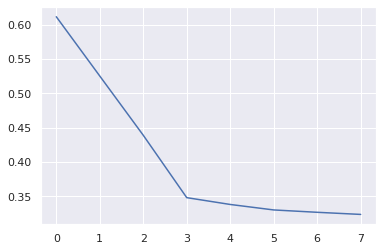

In [43]:
f1_macro_res.sort_index().reset_index(drop=True).plot()

In [44]:
f1_scores_models['xgb'] = f1_macro_res

In [45]:
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


model = make_pipeline(
    StandardScaler(),
    MultiOutputClassifier(RidgeClassifier(random_state=17)))

In [26]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=RidgeClassifier(random_state=17)))])

In [27]:
preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=lead_cols)

In [28]:
f1_weighted_res = columnwise_score(f1_score, preds, y_test, average='macro')

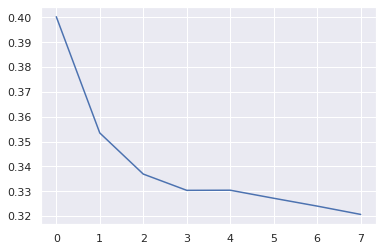

In [29]:
f1_weighted_res.reset_index(drop=True).plot()

In [30]:
f1_scores_models['ridge'] = f1_weighted_res

In [31]:
model =  MultiOutputClassifier(RandomForestClassifier(random_state=17, n_jobs=-1))

model.fit(X_train, y_train)

preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=lead_cols)
f1_weighted_res = columnwise_score(f1_score, preds, y_test, average='macro')

In [32]:
f1_scores_models['rf'] = f1_weighted_res

In [48]:
pd.DataFrame(f1_scores_models)

,ridge,rf,xgb
category_lead_1,0.400267,0.521540,0.611545
category_lead_2,0.353470,0.401771,0.525279
category_lead_3,0.336907,0.334721,0.439096
category_lead_4,0.330356,0.330455,0.348292
category_lead_5,0.330405,0.322286,0.338374
category_lead_6,0.327168,0.320626,0.330399
category_lead_7,0.324009,0.320689,0.326978
category_lead_8,0.320657,0.320657,0.323890


In [ ]:
model =  MultiOutputClassifier(SVC(random_state=17))

model.fit(X_train, y_train)

preds = model.predict(X_test)
preds = pd.DataFrame(preds, columns=lead_cols)
f1_weighted_res = columnwise_score(f1_score, preds, y_test, average='macro')

In [ ]:
f1_scores_models['svc'] = f1_weighted_res

In [49]:
pd.DataFrame(f1_scores_models).to_excel(os.path.join(ROOT_PATH, 'results_f1_macro_time.xlsx'))